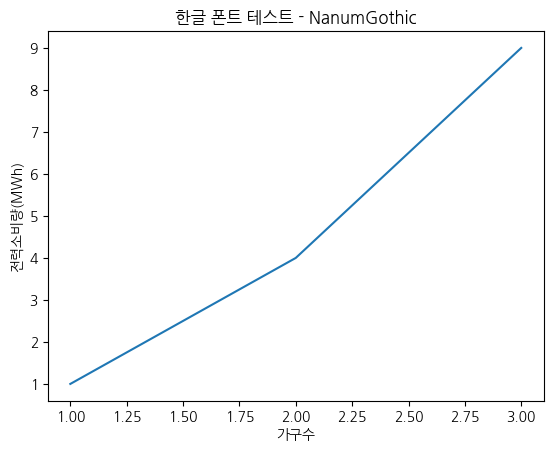

In [1]:
# 1) 나눔고딕 설치
!apt-get -qq install -y fonts-nanum > /dev/null

# 2) Matplotlib에 '파일 경로로' 폰트를 직접 등록 (재시작 불필요)
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import os

# 나눔고딕 파일 경로 (콜랩 기본 경로)
candidates = [
    "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
    "/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf",
    "/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf",
]
font_path = next((p for p in candidates if os.path.exists(p)), None)

if font_path is None:
    # 대체로 Noto CJK도 시도
    !apt-get -qq install -y fonts-noto-cjk > /dev/null
    candidates_noto = [
        "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",
        "/usr/share/fonts/opentype/noto/NotoSansCJKkr-Regular.otf",
        "/usr/share/fonts/opentype/noto/NotoSansCJK-Medium.ttc",
    ]
    font_path = next((p for p in candidates_noto if os.path.exists(p)), None)

if font_path is None:
    raise FileNotFoundError("한글 폰트 파일을 찾지 못했습니다. fonts-nanum 또는 fonts-noto-cjk 설치를 확인해주세요.")

# 인라인 등록 → 즉시 사용 가능
fm.fontManager.addfont(font_path)

# 폰트 패밀리 이름은 보통 파일 내 이름과 동일 (NanumGothic 또는 Noto Sans CJK KR)
# 안전하게 이름 후보를 몇 개 돌려서 먼저 적용되는 걸로 사용
possible_families = ["NanumGothic", "Nanum Gothic", "Noto Sans CJK KR", "Noto Sans CJK"]
for fam in possible_families:
    try:
        rcParams["font.family"] = fam
        rcParams["axes.unicode_minus"] = False
        # 테스트 플롯
        plt.figure()
        plt.title(f"한글 폰트 테스트 - {fam}")
        plt.plot([1,2,3], [1,4,9])
        plt.xlabel("가구수")
        plt.ylabel("전력소비량(MWh)")
        plt.show()
        break
    except Exception as e:
        continue


In [2]:
# [0] 기본 임포트 & 경로
import re, os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["axes.unicode_minus"] = False

DATA_PATH = "/content/시도별_세대수_1823.csv"   # 세대수 원본 CSV 경로


In [3]:
# [1] 파일 로드 + 지역명 정제(괄호 코드 제거 → 축약)
City_Family = pd.read_csv(DATA_PATH, encoding="cp949")
key_col = City_Family.columns[0]

In [4]:
City_Family.head(20)

행정구역 2018년12월_전체세대 2018년12월_1인세대 2018년12월_2인세대  \
0        전국  (1000000000)    22,042,947     8,085,526     4,929,337   
1     서울특별시  (1100000000)     4,263,868     1,679,049       891,792   
2     부산광역시  (2600000000)     1,480,468       532,193       354,350   
3     대구광역시  (2700000000)     1,021,266       344,096       234,512   
4     인천광역시  (2800000000)     1,213,201       407,706       265,665   
5     광주광역시  (2900000000)       603,107       211,663       130,851   
6     대전광역시  (3000000000)       624,965       225,131       135,800   
7     울산광역시  (3100000000)       461,756       143,657       100,801   
8   세종특별자치시  (3600000000)       123,762        39,699        25,021   
9       경기도  (4100000000)     5,306,214     1,779,427     1,117,005   
10  강원특별자치도  (5100000000)       707,245       292,968       173,295   
11     충청북도  (4300000000)       707,220       278,667       168,176   
12     충청남도  (4400000000)       943,611       376,190       223,702   
13     전라북도  (4500000000)       806,235       313,716       196,780   
14     전라남도  (4600000000)       860,303       361,281       213,347   
15     경상북도  (4700000000)     1,207,351       479,564       302,248   
16     경상남도  (4800000000)     1,425,271       505,587       334,894   
17  제주특별자치도  (5000000000)       287,104       114,932        61,098   

   2018년12월_3인세대 2018년12월_4인세대 2018년12월_5인세대 2018년12월_6인세대 2018년12월_7인세대  \
0      3,984,045     3,751,927       997,900       219,260        52,850   
1        768,663       704,778       168,321        37,669         9,452   
2        278,978       237,961        59,678        13,065         3,034   
3        198,747       186,532        45,355         9,292         2,041   
4        238,828       228,408        57,078        11,732         2,724   
5        111,004       107,893        33,174         6,568         1,366   
6        114,707       110,729        30,179         6,385         1,426   
7         93,980        95,884        22,177         3,995           911   
8         23,917        25,777         7,314         1,513           382   
9      1,021,477     1,051,942       262,829        55,045        13,108   
10       112,325        91,497        27,823         6,966         1,733   
11       115,396       103,810        31,460         7,338         1,683   
12       150,550       137,277        42,314         9,972         2,549   
13       129,623       112,534        39,995         9,818         2,565   
14       126,625       105,114        39,741        10,093         2,724   
15       196,925       166,465        47,050        11,243         2,690   
16       256,030       243,636        66,330        14,208         3,247   
17        46,270        41,690        17,082         4,358         1,215   

   2018년12월_8인세대  ... 2023년12월_1인세대 2023년12월_2인세대 2023년12월_3인세대 2023년12월_4인세대  \
0         13,983  ...     9,935,600     5,866,073     4,029,815     3,148,835   
1          2,699  ...     1,988,235       998,390       746,450       575,701   
2            762  ...       650,239       407,820       266,830       187,978   
3            444  ...       432,375       279,501       195,246       148,992   
4            696  ...       520,954       331,908       249,862       193,415   
5            363  ...       270,682       157,652       109,937        89,579   
6            402  ...       292,285       162,269       111,585        87,954   
7            228  ...       179,471       125,043        93,535        74,435   
8             91  ...        55,882        34,786        30,642        30,576   
9          3,584  ...     2,234,805     1,409,346     1,115,566       946,175   
10           404  ...       343,516       204,285       110,551        76,342   
11           391  ...       348,739       201,444       115,325        85,881   
12           662  ...       460,618       265,856       152,203       117,233   
13           694  ...       387,076       226,464       123,083        90,163   
14         

In [5]:
# 괄호 속 코드/잡공백 제거
City_Family[key_col] = (City_Family[key_col].astype(str)
    .str.replace("\u3000"," ", regex=False)            # 전각 공백
    .str.replace(r"\([^)]*\)", "", regex=True)         # 괄호(...) 전체 삭제
    .str.replace(r"\s+"," ", regex=True).str.strip())

# 축약 매핑
region_map = {
    "서울특별시":"서울","부산광역시":"부산","대구광역시":"대구","인천광역시":"인천",
    "광주광역시":"광주","대전광역시":"대전","울산광역시":"울산","세종특별자치시":"세종",
    "경기도":"경기","강원특별자치도":"강원","강원도":"강원",
    "충청북도":"충북","충청남도":"충남","전라북도":"전북","전북특별자치도":"전북",
    "전라남도":"전남","경상북도":"경북","경상남도":"경남","제주특별자치도":"제주","전국":"전국"
}
City_Family[key_col] = City_Family[key_col].replace(region_map)


In [6]:
# [2] 세대수 컬럼명 정규화: '2018년12월_1인세대' → '18년_1인세대'
def normalize_family_columns(df):
    new_cols = {}
    for c in df.columns:
        s = str(c)
        m4 = re.match(r"^(\d{4})년\d{1,2}월[_ ]?(.*세대)$", s)   # 2018년12월_1인세대
        if m4:
            new_cols[c] = f"{m4.group(1)[2:]}년_{m4.group(2)}"  # 18년_1인세대
        else:
            new_cols[c] = s
    return df.rename(columns=new_cols)

City_Family = normalize_family_columns(City_Family)


In [7]:
# [3] 숫자형 변환 + '전국' 행 제거 + 키 통일('지역')
fam_cols_all = [c for c in City_Family.columns if ("년_" in c and "세대" in c)]
for c in fam_cols_all:
    City_Family[c] = pd.to_numeric(
        City_Family[c].astype(str).str.replace(",","",regex=False).str.replace(" ","",regex=False),
        errors="coerce"
    )

# 전국 제거(있을 때만)
City_Family = City_Family[City_Family[key_col] != "전국"].reset_index(drop=True)
City_Family = City_Family.rename(columns={key_col:"지역"})
print("샘플 지역명:", City_Family["지역"].unique()[:8])


샘플 지역명: ['서울' '부산' '대구' '인천' '광주' '대전' '울산' '세종']


In [8]:
# [4] 시도별 전체세대 합계 테이블(City_HH) 생성
def build_city_hh(df):
    d = {}
    for c in df.columns:
        m2 = re.match(r"^(\d{2})년_전체세대$", str(c))  # 18년_전체세대
        if m2:
            y = f"20{int(m2.group(1)):02d}"            # 2018
            d.setdefault(y, df.groupby("지역")[c].sum())
    out = pd.DataFrame(d).reset_index()
    year_cols = sorted([c for c in out.columns if c.isdigit()], key=int)
    return out[["지역"] + year_cols]

City_HH = build_city_hh(City_Family)
years = [c for c in City_HH.columns if c.isdigit()]
print("연도:", years)


연도: ['2018', '2019', '2020', '2021', '2022', '2023']


In [9]:
City_Family.head(20)

지역  18년_전체세대  18년_1인세대  18년_2인세대  18년_3인세대  18년_4인세대  18년_5인세대  18년_6인세대  \
0   서울   4263868   1679049    891792    768663    704778    168321     37669   
1   부산   1480468    532193    354350    278978    237961     59678     13065   
2   대구   1021266    344096    234512    198747    186532     45355      9292   
3   인천   1213201    407706    265665    238828    228408     57078     11732   
4   광주    603107    211663    130851    111004    107893     33174      6568   
5   대전    624965    225131    135800    114707    110729     30179      6385   
6   울산    461756    143657    100801     93980     95884     22177      3995   
7   세종    123762     39699     25021     23917     25777      7314      1513   
8   경기   5306214   1779427   1117005   1021477   1051942    262829     55045   
9   강원    707245    292968    173295    112325     91497     27823      6966   
10  충북    707220    278667    168176    115396    103810     31460      7338   
11  충남    943611    376190    223702    150550    137277     42314      9972   
12  전북    806235    313716    196780    129623    112534     39995      9818   
13  전남    860303    361281    213347    126625    105114     39741     10093   
14  경북   1207351    479564    302248    196925    166465     47050     11243   
15  경남   1425271    505587    334894    256030    243636     66330     14208   
16  제주    287104    114932     61098     46270     41690     17082      4358   

    18년_7인세대  18년_8인세대  ...  23년_1인세대  23년_2인세대  23년_3인세대  23년_4인세대  23년_5인세대  \
0       9452      2699  ...   1988235    998390    746450    575701    124637   
1       3034       762  ...    650239    407820    266830    187978     41343   
2       2041       444  ...    432375    279501    195246    148992     31204   
3       2724       696  ...    520954    331908    249862    193415     44121   
4       1366       363  ...    270682    157652    109937     89579     22842   
5       1426       402  ...    292285    162269    111585     87954     21074   
6        911       228  ...    179471    125043     93535     74435     15005   
7        382        91  ...     55882     34786     30642     30576      7410   
8      13108      3584  ...   2234805   1409346   1115566    946175    217141   
9       1733       404  ...    343516    204285    110551     76342     20286   
10      1683       391  ...    348739    201444    115325     85881     22932   
11      2549       662  ...    460618    265856    152203    117233     31194   
12      2565       694  ...    387076    226464    123083     90163     27002   
13      2724       775  ...    428967    241021    120405     86746     26796   
14      2690       708  ...    584723    345445    184979    127545     31694   
15      3247       786  ...    623016    400419    254247    192044     45323   
16      1215       294  ...    134017     74424     49369     38076     13228   

    23년_6인세대  23년_7인세대  23년_8인세대  23년_9인세대  23년_10인이상세대  
0      26772      6429      1817       587          399  
1       7845      1768       463       156          146  
2       5346      1071       246        74           93  
3       8137      1791       449       146          129  
4       3720       714       196        52           59  
5       3903       858       205        57           71  
6       2522       497       109        36           37  
7       1188       258        57        25           11  
8      41998      9714      2598       786          595  
9       4225      1055       235        65           75  
10      4285       943       255        84           79  
11      6293      1455       365       101          131  
12      5533      1292       301       102          177  
13      5597      1310       356        94          150  
14      6166      1368       313        99          168  
15      8053      1692       405       119          184  
16      3043       749       172        48           29  

[17 rows x 67 columns]

In [10]:
City_HH.head(20)

지역     2018     2019     2020     2021     2022     2023
0   강원   707245   719524   736301   746220   755481   760635
1   경기  5306214  5468920  5676401  5841995  5913694  5978724
2   경남  1425271  1450822  1484601  1505971  1516930  1525502
3   경북  1207351  1227548  1254662  1276846  1286873  1282500
4   광주   603107   616485   633582   645712   652355   655433
5   대구  1021266  1031251  1056627  1063893  1070873  1094148
6   대전   624965   635343   652783   664417   673429   680261
7   부산  1480468  1497908  1530431  1544663  1555867  1564588
8   서울  4263868  4327605  4417954  4426007  4446296  4469417
9   세종   123762   135408   144275   153649   159386   160835
10  울산   461756   468659   476893   482650   486143   490690
11  인천  1213201  1238641  1267956  1298647  1322632  1350912
12  전남   860303   872628   893152   903108   907710   911442
13  전북   806235   816191   836660   849001   855849   861193
14  제주   287104   293155   302033   307529   311355   313155
15  충남   943611   959255   983153  1001915  1019093  1035449
16  충북   707220   722123   745644   760672   771848   779967

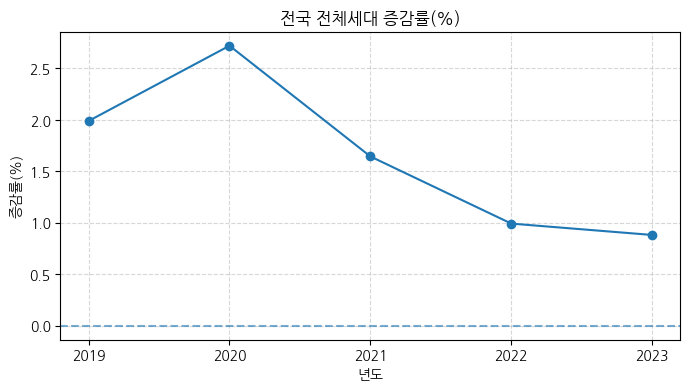

In [11]:
# 전국 전체세대 추이 & 증감률
nat_hh = City_HH[years].sum()
growth = nat_hh.pct_change()*100

plt.figure(figsize=(8,4))
plt.plot(years, (nat_hh/1e4).values, marker="o")
plt.title("전국 전체세대 추이 (만 세대)"); plt.xlabel("년도"); plt.ylabel("세대수(만)")
plt.grid(True, linestyle="--", alpha=0.5); plt.show()

plt.figure(figsize=(8,4))
plt.plot(years, growth.values, marker="o")
plt.title("전국 전체세대 증감률(%)"); plt.xlabel("년도"); plt.ylabel("증감률(%)")
plt.axhline(0, linestyle="--", alpha=0.6); plt.grid(True, linestyle="--", alpha=0.5); plt.show()


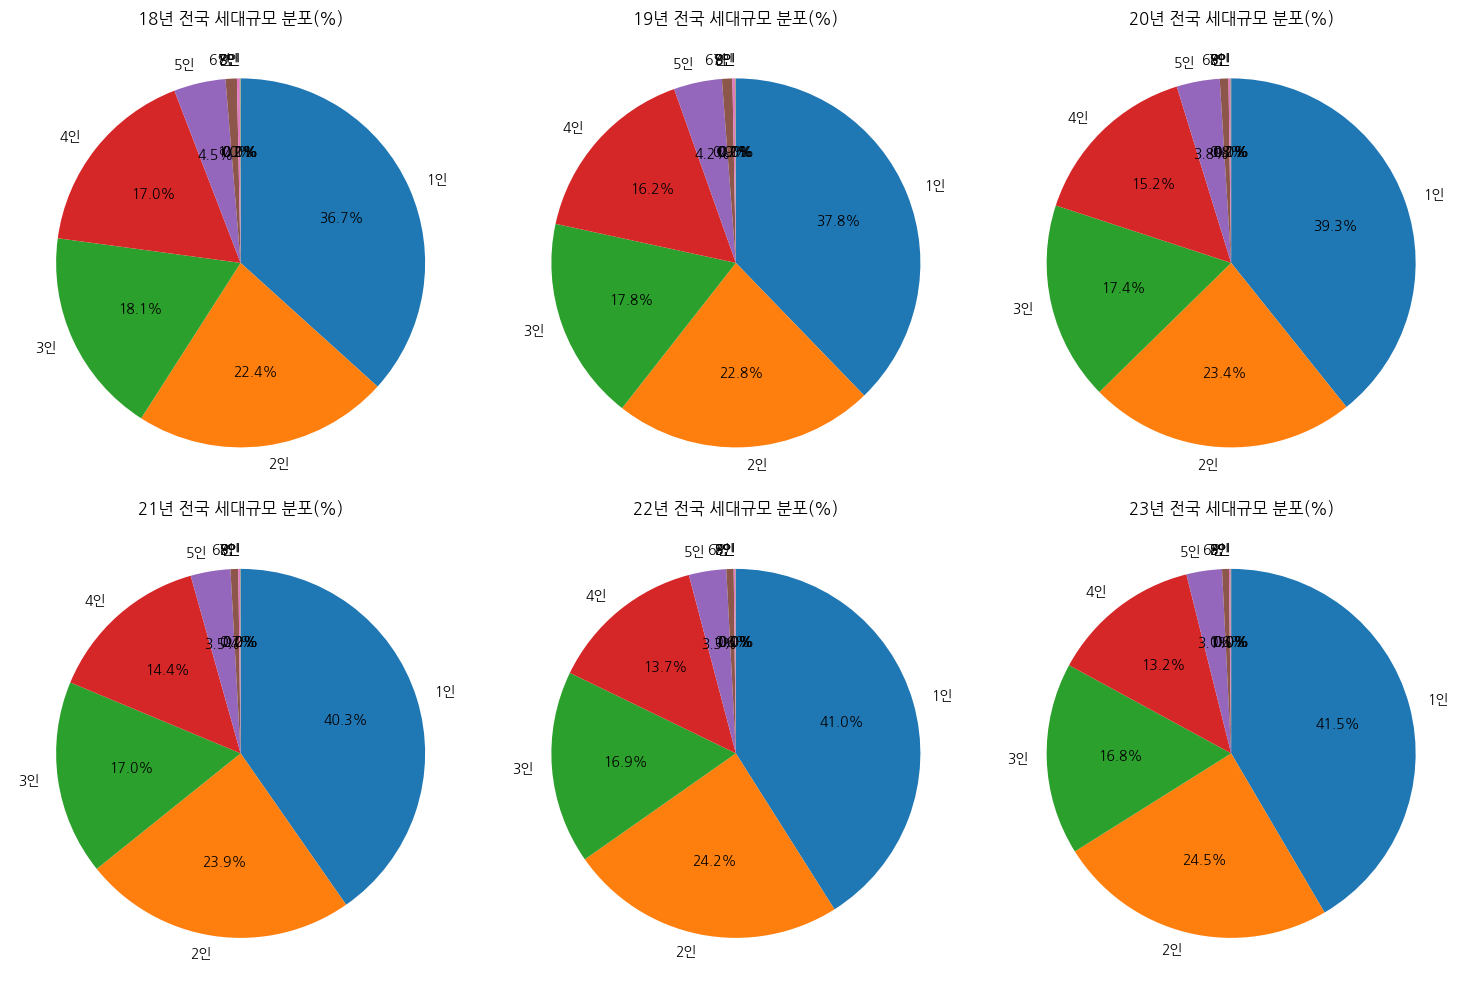

In [12]:
#  연도별 전국 1~10인 세대 분포(파이)
years_yy = [f"{int(y)%100:02d}년" for y in years]
fig, axes = plt.subplots(2, 3, figsize=(15,10))

for i, yy in enumerate(years_yy):
    ax = axes[i//3, i%3]
    tot = f"{yy}_전체세대"
    size_cols = [f"{yy}_{n}인세대" for n in range(1,11)]
    size_cols = [c for c in size_cols if c in City_Family.columns]
    if tot not in City_Family.columns or not size_cols:
        ax.set_title(f"{yy} 데이터 없음"); ax.axis("off"); continue
    total = City_Family[tot].sum()
    vals = City_Family[size_cols].sum()
    ratios = (vals/total*100).round(2)
    labels = [re.search(r"_(\d+)인세대$", c).group(1)+"인" for c in size_cols]
    ax.pie(ratios.values, labels=labels, autopct="%.1f%%", startangle=90, counterclock=False)
    ax.set_title(f"{yy} 전국 세대규모 분포(%)")
plt.tight_layout(); plt.show()


In [13]:
# 전국 1~4인 세대 비중 추이(라인)
def share_series(n):
    xs, s = [], []
    for y in years:
        yy = f"{int(y)%100:02d}년"
        tot, ncol = f"{yy}_전체세대", f"{yy}_{n}인세대"
        if tot in City_Family.columns and ncol in City_Family.columns:
            T = City_Family[tot].sum(); N = City_Family[ncol].sum()
            if T: xs.append(y); s.append(N/T*100)
    return xs, s

plt.figure(figsize=(10,6))
for n in [1,2,3,4]:
    xs, s = share_series(n)
    if xs: plt.plot(xs, s, marker="o", label=f"{n}인")
plt.title("전국 1~4인 가구 비중 추이(%)"); plt.xlabel("년도"); plt.ylabel("비중(%)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.show()


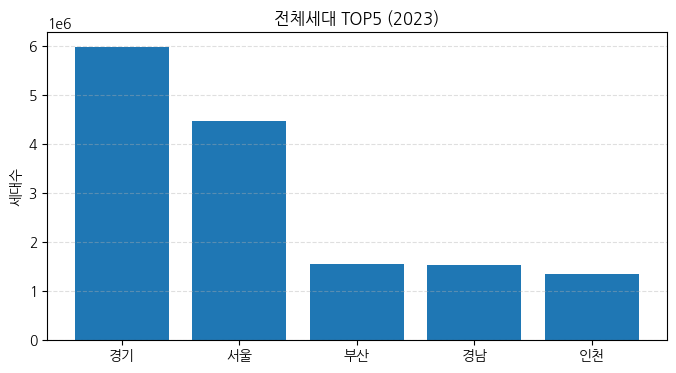

In [14]:
# 최신연도 기준 TOP5 / 하위5 (세대수)
latest = max(years, key=int)
top5 = City_HH.nlargest(5, latest)[["지역", latest]]
bot5 = City_HH.nsmallest(5, latest)[["지역", latest]]

plt.figure(figsize=(8,4))
plt.bar(top5["지역"], top5[latest]); plt.title(f"전체세대 TOP5 ({latest})")
plt.ylabel("세대수"); plt.grid(axis="y", linestyle="--", alpha=0.4); plt.show()



In [15]:
# 세대 소형화 지표: (1~2인 비중) − (4인 이상 비중)
def compact_index(yy2):                      # yy2: '18','19',...
    tot = City_Family.get(f"{yy2}년_전체세대")
    if tot is None: return np.nan
    one = City_Family.get(f"{yy2}년_1인세대", pd.Series(0)).sum()
    two = City_Family.get(f"{yy2}년_2인세대", pd.Series(0)).sum()
    fourp = sum(City_Family.get(f"{yy2}년_{n}인세대", pd.Series(0)).sum() for n in range(4,11))
    T = tot.sum();
    return np.nan if not T else (one+two)/T*100 - fourp/T*100

xs = years
vals = [compact_index(f"{int(y)%100:02d}") for y in years]

plt.figure(figsize=(8,4))
plt.plot(xs, vals, marker="o"); plt.title("세대 소형화 지표 추이 ((1~2인) - (4인 이상))")
plt.xlabel("년도"); plt.ylabel("퍼센트 포인트")
plt.grid(True, linestyle="--", alpha=0.5); plt.show()
